# AI-Driven Solar Power Operations Optimizer
## Data Extraction
In this section, we will open and view the 2 datasets weather and air_quality to find for identical columns using DB Browser. Open Jupyter Notebook to extract and merge the 2 datasets.

**Steps**:
1. Load the data
2. Ensure consistent data types by converting the date column to datetime type in both DataFrames.
3. Merge the datasets with 2 identical columns "data_ref" and "date"
4. Save the merged dataframe. You can open and view it anytime using DB browser. 

Note: Dates can vary in format and may contain errors or inconsistencies. Setting dayfirst=True is very important, it sort the day first follow by month then by year.

In [1]:
import sqlite3
import pandas as pd

# View both the datasets in DB Browser to find the identical columns to merge
## Please change to your datasets path
db1_path = 'C:/Users/summe/Downloads/AISG/data/air_quality.db'
db2_path = 'C:/Users/summe/Downloads/AISG/data/weather.db'

# Function to load table
def load_table(db_path, table_name):
    with sqlite3.connect(db_path) as conn:
        return pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Load the tables into DataFrames
df1 = load_table(db1_path, 'air_quality')
df2 = load_table(db2_path, 'weather')

In [2]:
# Ensure the date columns are of the same type
df1['date'] = pd.to_datetime(df1['date'], dayfirst=True)
df2['date'] = pd.to_datetime(df2['date'], dayfirst=True)

# Merge both datasets using 'date' and 'data_ref' columns
merged_df = pd.merge(df1, df2, on=['date', 'data_ref'])

In [3]:
# Save the merged DataFrame to a new database for easy reference
merged_db_path = 'C:/Users/summe/Downloads/AISG/data/merged_db.sqlite'
with sqlite3.connect(merged_db_path) as conn_merged:
    merged_df.to_sql('merged_table', conn_merged, index=False, if_exists='replace')

print(f"Merged data has been saved to {merged_db_path}")

Merged data has been saved to C:/Users/summe/Downloads/AISG/data/merged_db.sqlite


# Understanding the merged dataset
I noticed weather dataset has 3517 rows while air quality data has 3875 rows
After merge, the data has 4258 rows which indicate both datas have differences in date recorded.

1. let's check the unique dates and the number of records before and after the merge

In [4]:
# Check the unique dates in each data
unique_dates_df1 = df1['date'].nunique()
unique_dates_df2 = df2['date'].nunique()
unique_dates_merged = merged_df['date'].nunique()

# Display the results
print(f"Unique dates in df1: {unique_dates_df1}")
print(f"Unique dates in df2: {unique_dates_df2}")
print(f"Unique dates in merged_df: {unique_dates_merged}")

# Check the number of records in each data
print(f"Number of records in df1: {df1.shape[0]}")
print(f"Number of records in df2: {df2.shape[0]}")
print(f"Number of records in merged_df: {merged_df.shape[0]}")

Unique dates in df1: 3197
Unique dates in df2: 3197
Unique dates in merged_df: 3197
Number of records in df1: 3875
Number of records in df2: 3517
Number of records in merged_df: 4258


**From above, it show equal unique dates in df1, df2 and merged_df which indicate the existence of duplicates.**

1. The exact amount of duplicates in Number of records in df1 - unique dates in df1, 3875 - 3197 = 678 duplicates in df1 which is the air_quality data.
2. The exact amount of duplicates in Number of records in df2 - unique dates in df2, 3517 - 3197 = 320 duplicates in df2 which is the weather data.
3. The exact amount of duplicates in Number of records in merged_df - unique dates in merged_df, 4258 - 3197 = 1061 duplicates in merged data.

In [5]:
# Drop duplicates in 'date' column
merged_df.drop_duplicates(subset=['date'], keep='first', inplace=True)

# Display the updated data
print("DataFrame no. of rows after removing duplicates:\n", merged_df.shape[0])

# Now you can save the updated DataFrame to a new database
# merged_db_path = 'C:/Users/summe/Downloads/AISG/data/merged_db.sqlite'
# with sqlite3.connect(merged_db_path) as conn_merged:
    # merged_df.to_sql('merged_table', conn_merged, index=False, if_exists='replace')

print(f"Merged data with duplicates removed has been saved to {merged_db_path}")

DataFrame no. of rows after removing duplicates:
 3197
Merged data with duplicates removed has been saved to C:/Users/summe/Downloads/AISG/data/merged_db.sqlite


# Check the data types and assign the appropriate data type to the columns.

**Steps:**
1. check the dataframe info.
2. Assign the appropriate data type to the columns.

Note: some of the columns might consist of mixed data type. For example, if the column is temperature the data type should be a float but sometimes we have special symbols like --, -, _, *, @, etc in the column. Thus, during conversion add in errors='coerce' it cause any value that cannot be converted to the desired type are replaced with NaN (Not a Number). And we will deal with the NaN and missing values at the next stage.

In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3197 entries, 0 to 4256
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   data_ref                       3197 non-null   object        
 1   date                           3197 non-null   datetime64[ns]
 2   pm25_north                     3158 non-null   object        
 3   pm25_south                     3158 non-null   object        
 4   pm25_east                      3158 non-null   object        
 5   pm25_west                      3158 non-null   object        
 6   pm25_central                   3158 non-null   object        
 7   psi_north                      3197 non-null   object        
 8   psi_south                      3197 non-null   object        
 9   psi_east                       3197 non-null   object        
 10  psi_west                       3197 non-null   object        
 11  psi_central      

In [7]:
# I would prefer float and int are store as 32 bits instead of 64 bits as the data types display above. 
## When dealing with big data where reducing memory usage can significantly improve performance and reduce storage costs.
### Convert multiple columns to numeric
columns_to_convert = ['pm25_north', 'pm25_south', 'pm25_east', 'pm25_west', 'pm25_central', 'psi_north', 'psi_south',
                      'psi_east', 'psi_west', 'psi_central']

# Convert each column to int using pd.to_numeric with errors='coerce' it convert non-numeric values to NaN.
for col in columns_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# List of columns to convert to float
columns_to_convert2 = ['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)',
                      'Min Temperature (deg C)', 'Maximum Temperature (deg C)', 'Min Wind Speed (km/h)', 'Max Wind Speed (km/h)']

# Convert each column to float using pd.to_numeric with errors='coerce' it convert non-numeric values to NaN.
for col in columns_to_convert2:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce').astype(float)

print("\nDataFrame after conversion:")
print(merged_df.info())


DataFrame after conversion:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3197 entries, 0 to 4256
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   data_ref                       3197 non-null   object        
 1   date                           3197 non-null   datetime64[ns]
 2   pm25_north                     2852 non-null   float64       
 3   pm25_south                     2848 non-null   float64       
 4   pm25_east                      2853 non-null   float64       
 5   pm25_west                      2850 non-null   float64       
 6   pm25_central                   2849 non-null   float64       
 7   psi_north                      2887 non-null   float64       
 8   psi_south                      2890 non-null   float64       
 9   psi_east                       2885 non-null   float64       
 10  psi_west                       2887 non-null   float64 

# Let's check all the numeric columns that consists of negative values. 
From the column names, there should not be any negative value. Sometimes, if the data is thoroughly cleaned but you can find negative values this might be directional indication.

**Steps:**
1. Display negative values in your dataframe columns.
2. Make the columns absolute.

In [8]:
import numpy as np

# Detect rows with negative values
negative_values_df = merged_df[(merged_df.select_dtypes(include=[np.number]) < 0).any(axis=1)]

print("Rows containing negative values:")
print(negative_values_df)

Rows containing negative values:
                                  data_ref       date  pm25_north  pm25_south  \
0     4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea 2014-04-01        20.0        16.0   
9     7ed261dd-050b-4ed2-aaaa-864b40814844 2014-04-09         NaN        12.0   
10    bbbf4449-812f-4127-8bf5-84f909dd04c3 2014-04-10        19.0        12.0   
26    e0506d21-2d2a-4e7b-8db7-26649ef8973e 2014-04-25        26.0        21.0   
45    60dfdbc0-6c14-4a5d-9652-bd0e3ecb365b 2014-05-12        18.0        15.0   
...                                    ...        ...         ...         ...   
4166  9b68edf4-d1b5-40b9-817b-afe6f9cdab08 2022-12-24         NaN         NaN   
4172  8c9a7da3-3e0e-4265-b2fa-4e8ac2f535be 2022-12-30         NaN        14.0   
4178  52a9cb85-3a9a-4b88-bf5a-dd3a42ef8b7d 2021-07-07         NaN         NaN   
4182  cba8f618-0e80-482a-bf02-beab1099f21e 2018-11-19         NaN         NaN   
4226  02b1b301-119b-439c-9f7f-19d7f3d6406d 2017-10-26         NaN         Na

In [9]:
# Not possible for Max Wind Speed and Wet Bulb Termperature to have negative values. 
## List of columns to compute absolute values
columns_to_abs = ['Max Wind Speed (km/h)', 'Wet Bulb Temperature (deg F)']

# Apply absolute values for selected columns
merged_df[columns_to_abs] = merged_df[columns_to_abs].abs()

# Now you can save the updated DataFrame to a new database
merged_db_path = 'C:/Users/summe/Downloads/AISG/data/merged_db.sqlite'
with sqlite3.connect(merged_db_path) as conn_merged:
    merged_df.to_sql('merged_table', conn_merged, index=False, if_exists='replace')

# We will proceed to visualize any missing values in the data. 
If there are missing values, we have to understand the distribution of the data before we can decide which methods to fill up the missing values.

**Steps:**
1. Display your data using MissingNo Matrix.
2. Plot your data in box plot for all columns with numeric values.

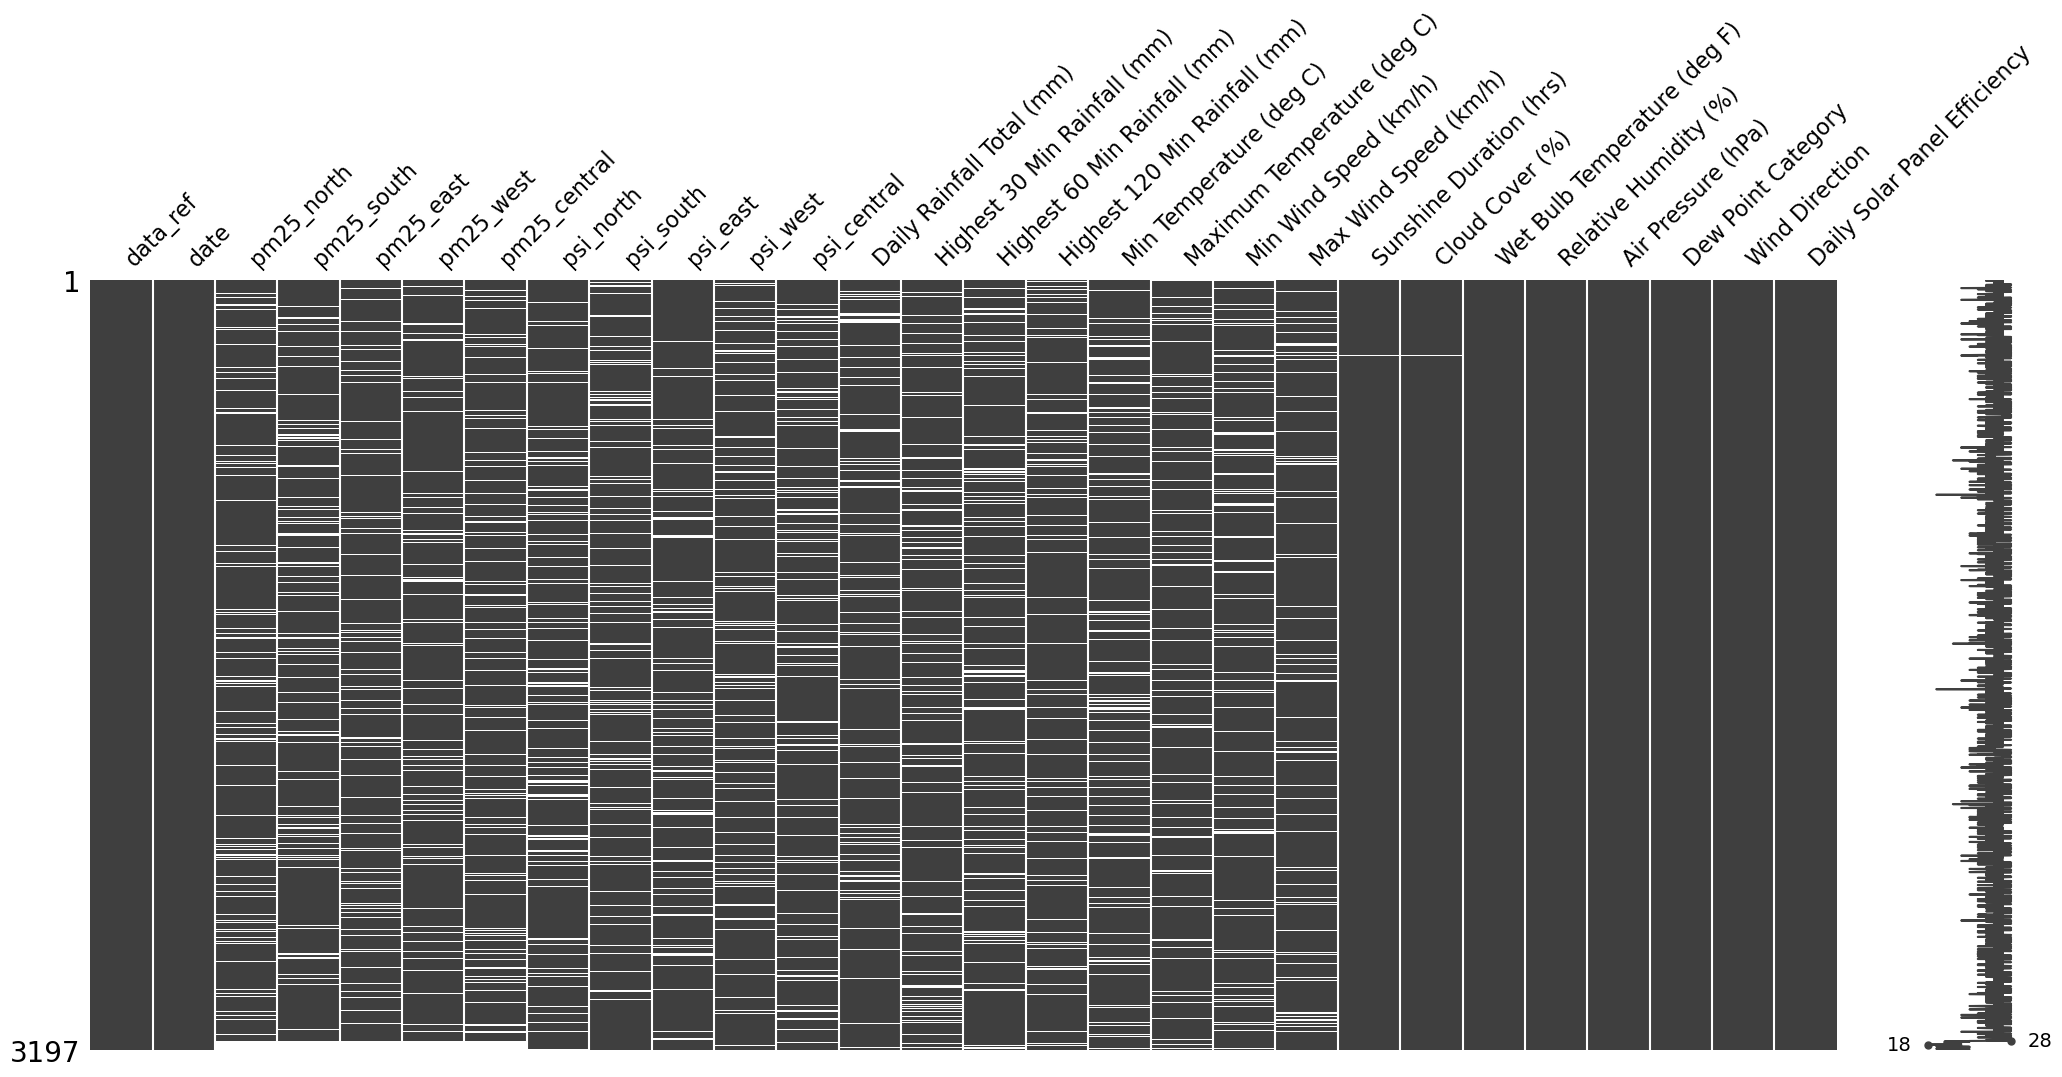

In [10]:
# Visualize missing values in my data
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(merged_df)
plt.show()

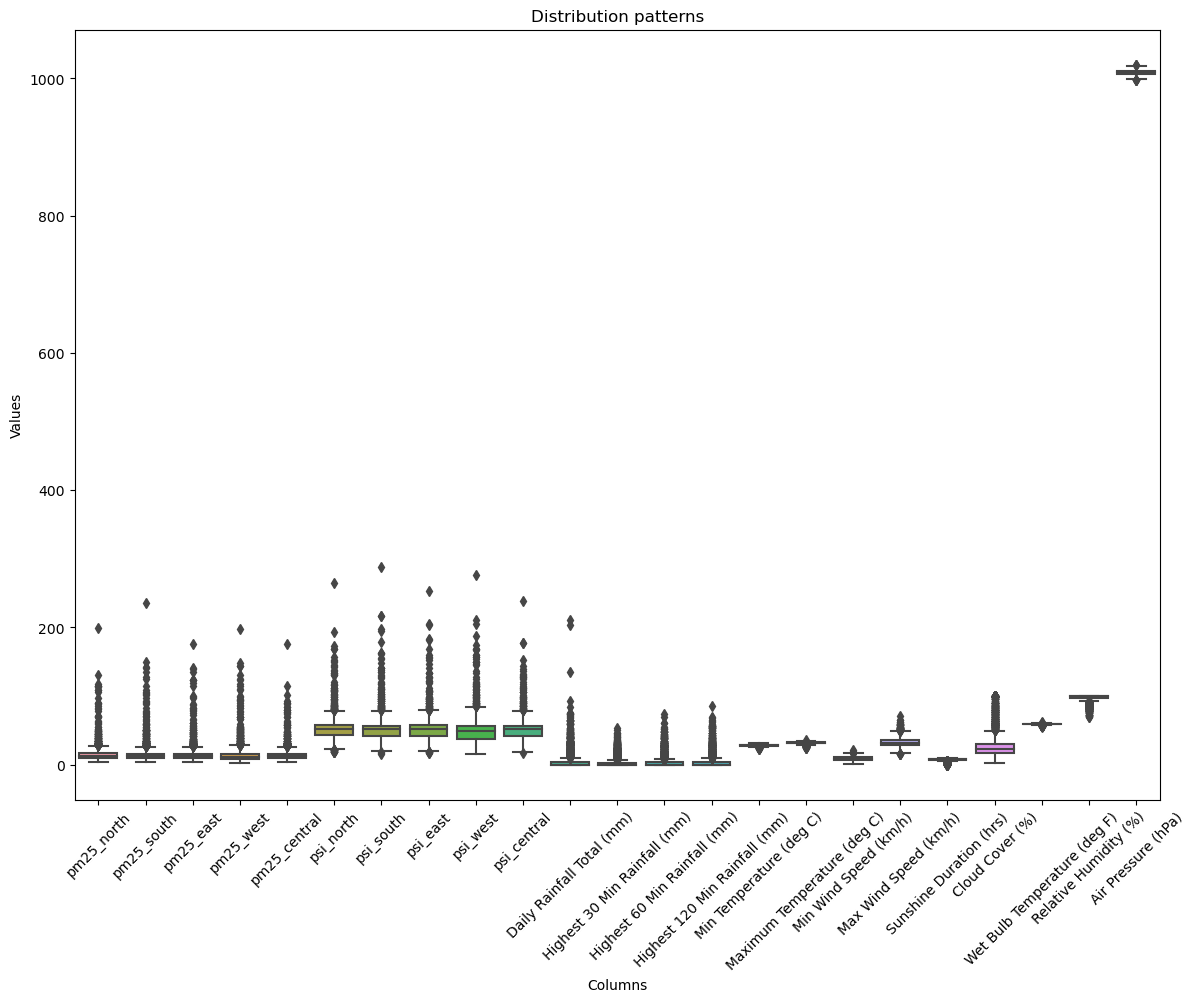

In [11]:
# Visualize the distribution patterns in columns before deciding which methods to fill up all the missing values.
import seaborn as sns

numeric_columns = merged_df.select_dtypes(include=[np.number]).columns.tolist()

# Using box plot to visualize outliers in numeric columns
plt.figure(figsize=(14, 10))
sns.boxplot(data=merged_df[numeric_columns])
plt.title('Distribution patterns')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

# What to do with data contains a lot of outliers?
For columns with a lot of outliers, we apply interquartile range to cap the outliers and use the median to fill missing values in the numerical columns.

**Steps:**
1. Apply interquartile range to cap outlier to each column.
2. Fill in the missing values with median.
3. Visualize any missing value in the dataframe.
4. Visualize the distribution patterns again.

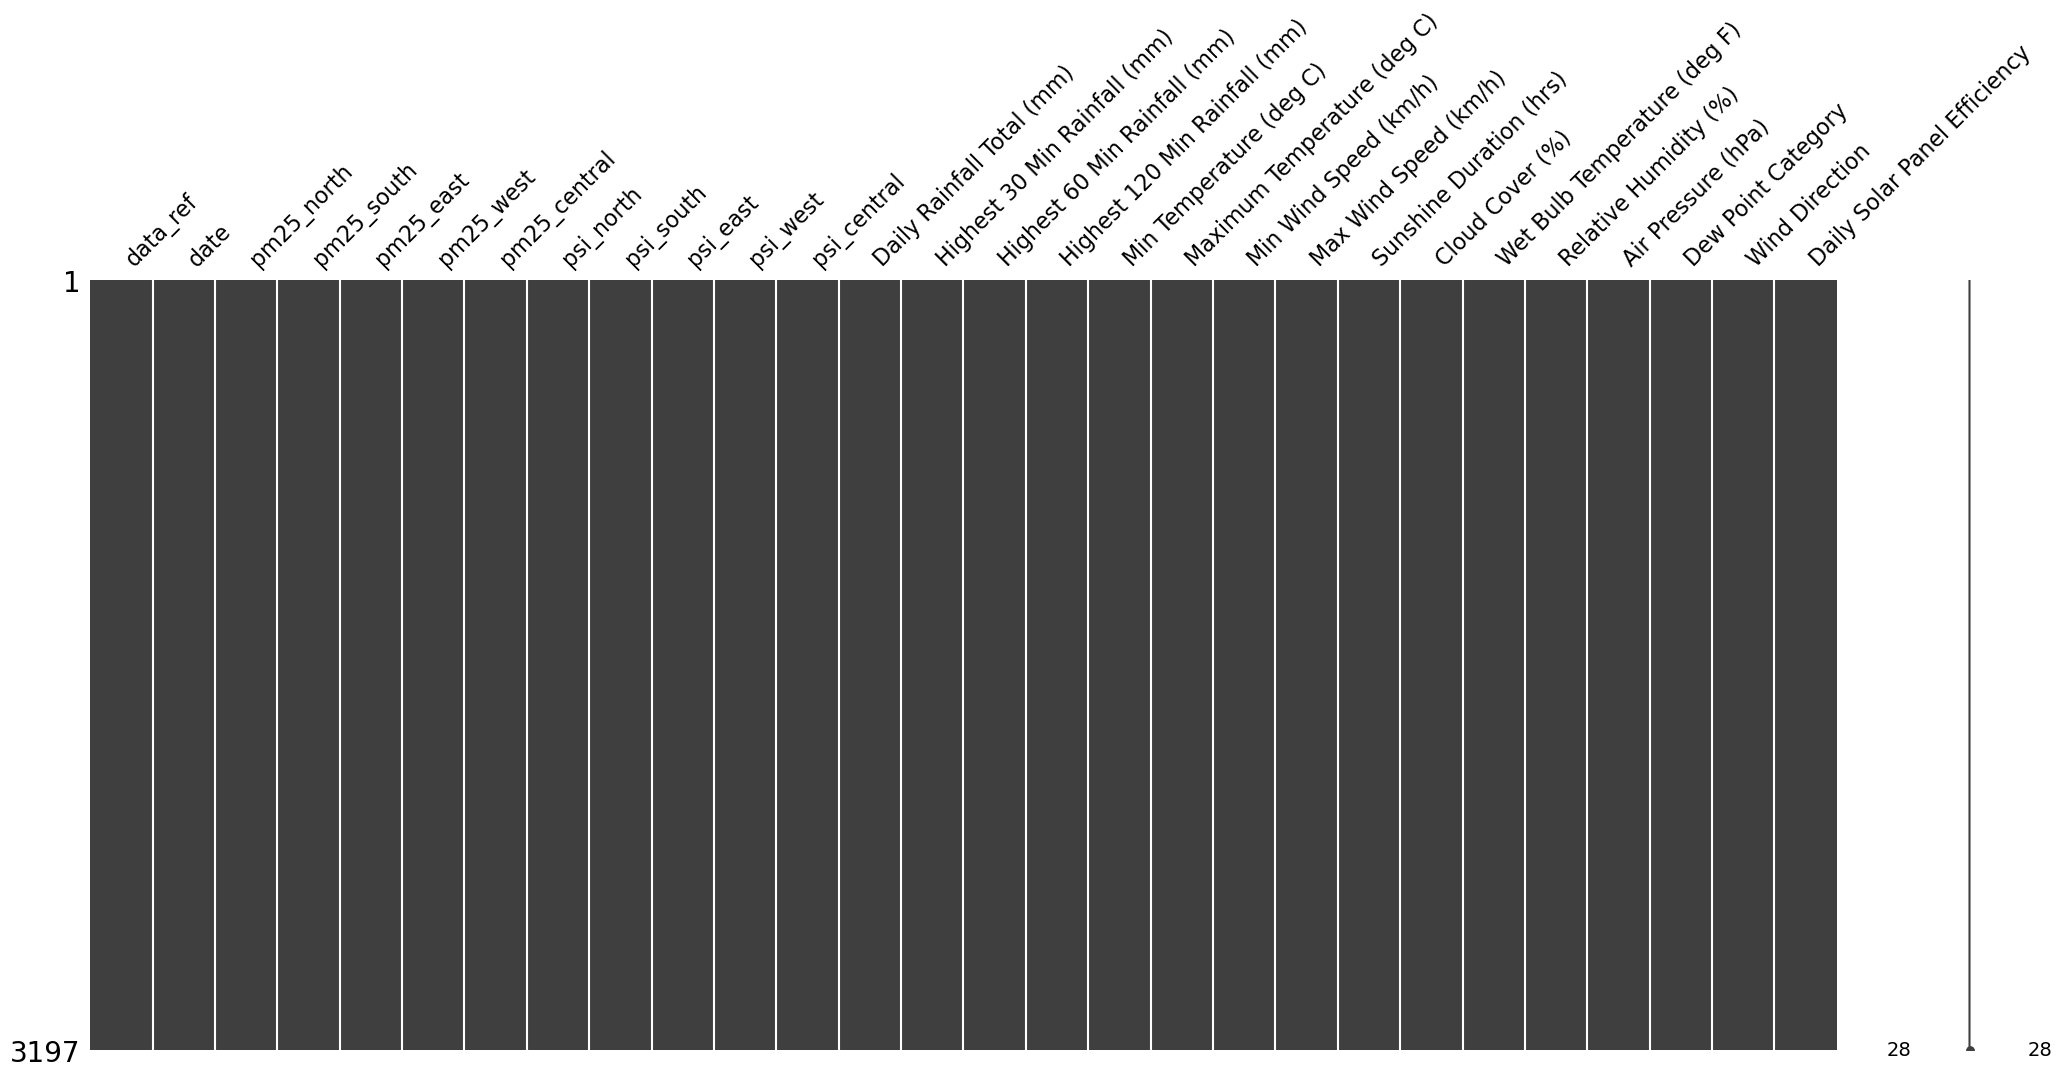

In [12]:
# When dealing with missing values in data that contains a lot of outliers, we use interquartile range to identify outliers and capping it
## helps ensure that the central tendency is accurately represented without being skewed by outliers. 
### The median provides a central value that is representative of the dataset, regardless of the presence of extreme values. 
from scipy.stats import mstats

# Function to cap outliers based on IQR
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

columns_to_process = ['pm25_north', 'pm25_south', 'pm25_east', 'pm25_west', 'pm25_central',
                      'psi_north', 'psi_south', 'psi_east', 'psi_west', 'psi_central',
                      'Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)', 
                      'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)', 
                      'Min Temperature (deg C)', 'Maximum Temperature (deg C)',
                      'Min Wind Speed (km/h)', 'Max Wind Speed (km/h)', 
                      'Sunshine Duration (hrs)', 'Cloud Cover (%)',
                      'Wet Bulb Temperature (deg F)', 'Relative Humidity (%)', 
                      'Air Pressure (hPa)']

# Cap outliers and fill up missing values for each column
for col in columns_to_process:    
    merged_df[col] = cap_outliers(merged_df[col])    
    merged_df[col].fillna(merged_df[col].median(), inplace=True)

# Visualize missing values after treatment
msno.matrix(merged_df)
plt.show()

# Save a copy just in case
merged_db_path = 'C:/Users/summe/Downloads/AISG/data/merged_db2.sqlite'

with sqlite3.connect(merged_db_path) as conn_merged:
    merged_df.to_sql('merged_table', conn_merged, index=False, if_exists='replace')

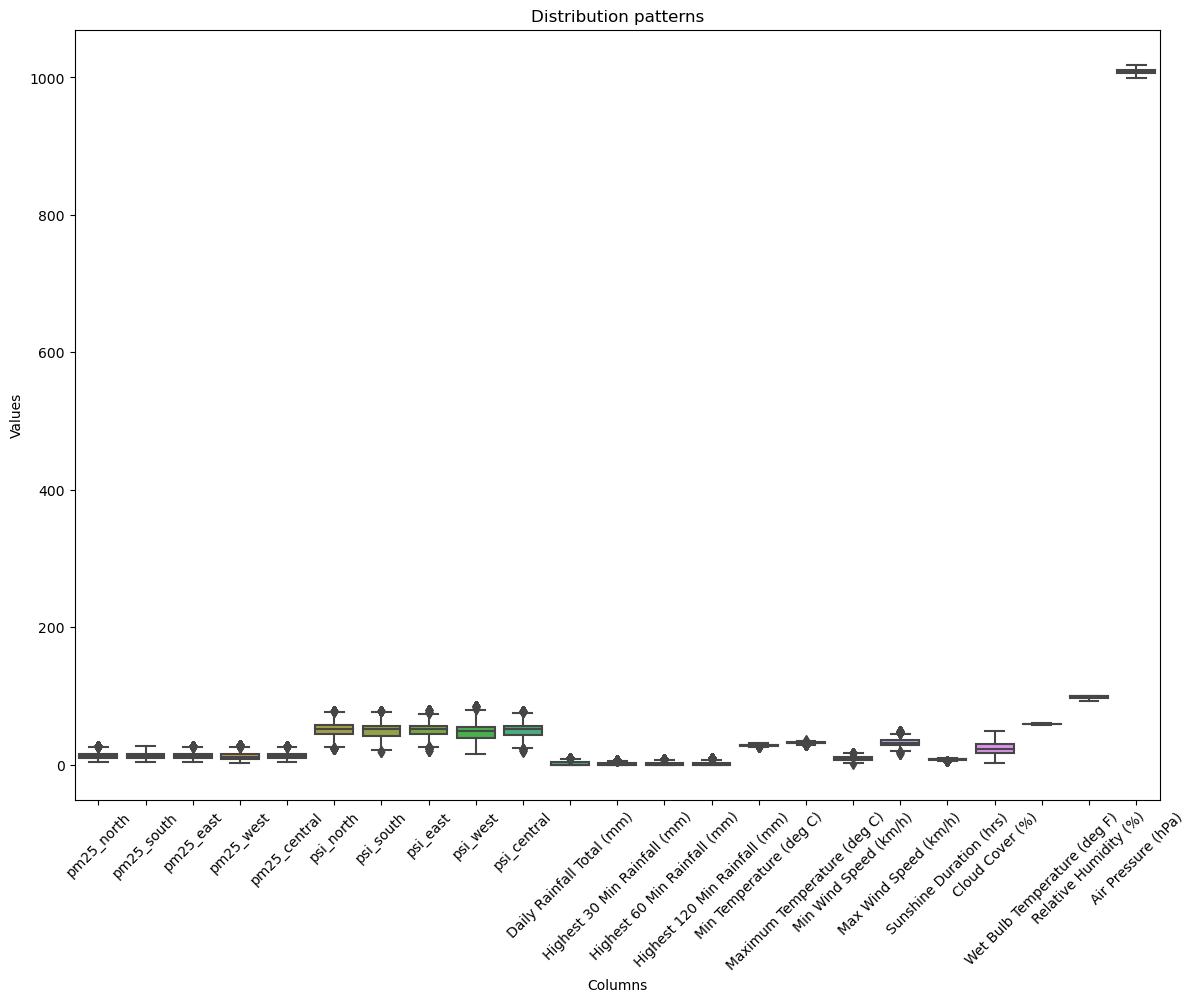

In [13]:
# Visualize the distribution patterns again
plt.figure(figsize=(14, 10))
sns.boxplot(data=merged_df[numeric_columns])
plt.title('Distribution patterns')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

# Visualize the MissingNo Matrix and boxplot again. 
You will notice all the missing values are filled and the outliers are capped.

# Next, we will be standardizing the categorical data in the "Dew Point Category", "Wind Direction" and "Daily Solar Panel Efficiency" columns to ensure consistency and accuracy in data analysis.

**Steps:**
1. Check unique words in those columns.
2. Replace all the identical words and abbreviations into a single word.

In [14]:
# Check unique words in the columns with words
columns_to_check = ['Dew Point Category', 'Wind Direction', 'Daily Solar Panel Efficiency']

unique_words = {}
for column in columns_to_check:
    unique_words[column] = merged_df[column].unique()

# Display the unique words for each column
for column, words in unique_words.items():
    print(f"Unique words in the column '{column}':")
    print(words)
    print()

Unique words in the column 'Dew Point Category':
['VH' 'Very High' 'Low' 'High' 'Moderate' 'Extreme' 'Very Low' 'very low'
 'LOW' 'VERY HIGH' 'High Level' 'very high' 'HIGH' 'H' 'M' 'moderate' 'VL'
 'MODERATE' 'high' 'Below Average' 'VERY LOW' 'Minimal' 'low' 'Normal' 'L']

Unique words in the column 'Wind Direction':
['W' 'S' 'E' 'east' 'NORTHEAST' 'NW' 'NE' 'SE' 'Southward' 'W.'
 'southeast' 'SW' 'N' 'Northward' 'SOUTHEAST' 'northwest' 'west' 'NORTH'
 'south' 'NE.' 'SE.' 'NORTHWEST' 'northeast' 'SW.' 'north' 'SOUTH' 'E.'
 'S.' 'NW.' 'WEST' 'N.' 'EAST']

Unique words in the column 'Daily Solar Panel Efficiency':
['High' 'Medium' 'Low']



In [15]:
# Replace identical words and abbreviations in lowercase words 
## Dew Point Category column replacements
dew_point_replacements = {
    'VH': 'very high', 'VERY HIGH': 'very high', 'Very High': 'very high',
    'L': 'low', 'Low': 'low', 'LOW': 'low',
    'High': 'high', 'HIGH': 'high', 'H': 'high', 'High Level': 'high',
    'Moderate': 'moderate', 'M': 'moderate', 'MODERATE': 'moderate',
    'Very Low': 'very low', 'VL': 'very low','Minimal':'very low', 'VERY LOW': 'very low',
    'Below Average': 'below average',
    'Extreme': 'extreme',
    'Normal': 'normal'
}

# Wind Direction column replacements
wind_direction_replacements = {
    'W': 'west', 'W.': 'west', 'WEST': 'west',
    'E': 'east', 'E.': 'east', 'EAST': 'east',
    'S': 'south', 'Southward': 'south', 'SOUTH': 'south', 'S.': 'south',
    'NORTHEAST': 'northeast', 'NE':'northeast', 'NE.': 'northeast',
    'N': 'north', 'NORTH': 'north', 'Northward': 'north', 'N.': 'north',
    'NW': 'northwest', 'NORTHWEST': 'northwest', 'NW.': 'northwest',
    'SOUTHEAST': 'southeast', 'SE': 'southeast', 'SE.': 'southeast',
    'SW': 'southwest', 'SW.': 'southwest'
    
}

# Apply replacements
merged_df['Dew Point Category'] = merged_df['Dew Point Category'].replace(dew_point_replacements)
merged_df['Wind Direction'] = merged_df['Wind Direction'].replace(wind_direction_replacements)

# Check the unique words again
columns_to_check = ['Dew Point Category', 'Wind Direction', 'Daily Solar Panel Efficiency']

unique_words = {}
for column in columns_to_check:
    unique_words[column] = merged_df[column].unique()

# Display the unique words again
for column, words in unique_words.items():
    print(f"Unique words in the column '{column}':")
    print(words)
    print()

Unique words in the column 'Dew Point Category':
['very high' 'low' 'high' 'moderate' 'extreme' 'very low' 'below average'
 'normal']

Unique words in the column 'Wind Direction':
['west' 'south' 'east' 'northeast' 'northwest' 'southeast' 'southwest'
 'north']

Unique words in the column 'Daily Solar Panel Efficiency':
['High' 'Medium' 'Low']



In [16]:
# Save a copy
merged_db_path = 'C:/Users/summe/Downloads/AISG/data/merged_db2.sqlite'

with sqlite3.connect(merged_db_path) as conn_merged:
    merged_df.to_sql('merged_table', conn_merged, index=False, if_exists='replace')

# Check the correlation between Daily Solar Panel Efficiency column with all other columns.

**Steps:**
1. Convert Dew Point Category and Daily Solar Panel Efficiency columns into numeric values.
2. Visualizes the correlation between all numeric columns using Heatmap.

Note: I will exclude Data_ref, date and Wind Direction columns because it do not contribute to Daily Solar Panel Efficiency.

In [17]:
# Replacing Dew Point Category column into numeric
replace_you = {
    'extreme': 0.9,
    'very high': 0.8,
    'high': 0.7,
    'moderate': 0.6,
    'normal': 0.5,
    'below average': 0.4,
    'low': 0.3,
    'very low': 0.1,    
}

merged_df2 = merged_df.copy()
merged_df2['Dew Point Category'] = merged_df2['Dew Point Category'].replace(replace_you)
# Convert data type to float
merged_df2['Dew Point Category'] = merged_df2['Dew Point Category'].astype(float)

# Replacing Solar Panel Efficiency column into numeric
replace_you2 = {
    'High': 1,
    'Medium': 0.5,
    'Low': 0
}

merged_df2['Daily Solar Panel Efficiency'] = merged_df2['Daily Solar Panel Efficiency'].replace(replace_you2)
# Convert data type to float
merged_df2['Daily Solar Panel Efficiency'] = merged_df2['Daily Solar Panel Efficiency'].astype(float)

# Check whether both the columns have updated correctly
print(merged_df2[['Dew Point Category', 'Daily Solar Panel Efficiency']])

      Dew Point Category  Daily Solar Panel Efficiency
0                    0.8                           1.0
1                    0.8                           0.5
2                    0.3                           0.5
3                    0.8                           0.5
4                    0.8                           0.0
...                  ...                           ...
4248                 0.6                           0.0
4250                 0.8                           0.5
4252                 0.7                           0.0
4254                 0.7                           0.5
4256                 0.8                           0.0

[3197 rows x 2 columns]


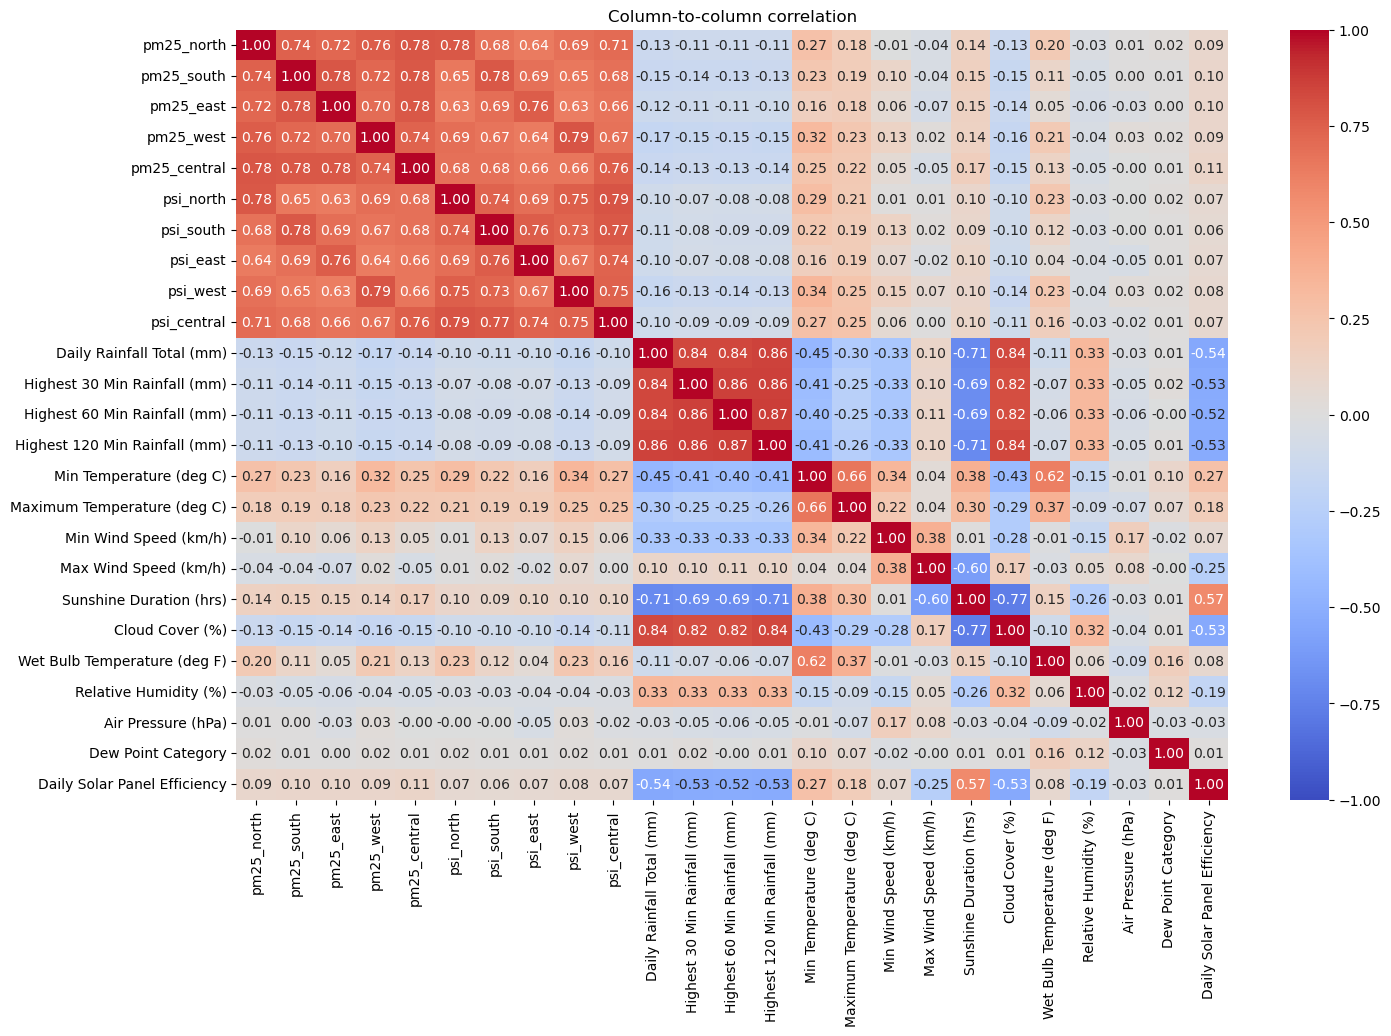

In [18]:
# Calculate the correlation matrix for numeric columns
corr_matrix = merged_df2.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Column-to-column correlation')
plt.show()

# From the heatmap, you can visualize:

1. High levels of pm 2.5 can reduce solar panel efficiency by causing soiling and blocking sunlight. Dust and pollutants on the panel surface can lower the amount of sunlight that reaches the photovoltaic cells. But with the data provided, pm 2.5 affect very minimally to solar panel efficiency. It is likely there is no signficant amount of pm 2.5 in the air that can impact the solar panel efficiency.
2. Psi, dew point category and air pressure have very minimal effects on the solar panel efficiency.
3. The rainfall contribute greatly to lessen the solar panel efficiency however, how heavy is the rain does not make a difference to solar panel efficiency.
4. Cooler temperature(deg C) make solar panel efficiency to perform better than warmer temperature(deg C).
5. Higher Wind speed make solar panel efficiency output lower, however, with low wind speed it help to cool down the solar panel thus very minimally improve the solar panel efficiency.
6. Sunshine Duration greatly increase the solar panel efficiency output.
7. Higher Cloud Cover(%) cause the solar panel efficiency to reduce significantly.
8. Wet bulb temperature can indicate the cooling potential of the environment. High wet bulb temperatures may suggest less cooling effect, potentially affecting panel efficiency. However, with the data provided it is not a factor contribute to solar panel efficiency.
9. High humidity(%) cause the solar panel system to heat up thus lowering the solar panel efficiency.

## Conclusion:
The main factors directly affecting solar panel efficiency are rainfall, sunshine duration and cloud cover. Temperature(deg C) and high wind speed affect moderately to solar panel efficiency. Strong winds can cause panels to shift from their optimal orientation if they are not securely mounted. Misalignment reduces the amount of sunlight that the panels capture, impacting their efficiency and from the data provided proved this.

The best timing to schedule maintenance on site are either night time or rainny days or cloud cover(%) is high. During sunny day or low cloud cover days you should consider increasing battery capacity to 
allows for the storage of excess power generate.d

In [19]:
# Save a copy
merged_db_path = 'C:/Users/summe/Downloads/AISG/data/merged_db_final.sqlite'

with sqlite3.connect(merged_db_path) as conn_merged:
    merged_df2.to_sql('merged_table', conn_merged, index=False, if_exists='replace')

# Data Insights
Highlighting operational efficiency and tracking trends in solar panel efficiency through the years.

**Steps:**
1. List the range of years to plot, add dummy data for the first three months of 2014(from the data provided it start at april 2014 onwards till whole year of 2022). Group Daily Solar Panel Efficiency column by month and create a subplot for each year.
2. Group Daily Solar Panel Efficiency column by year and plot the stacked bar.

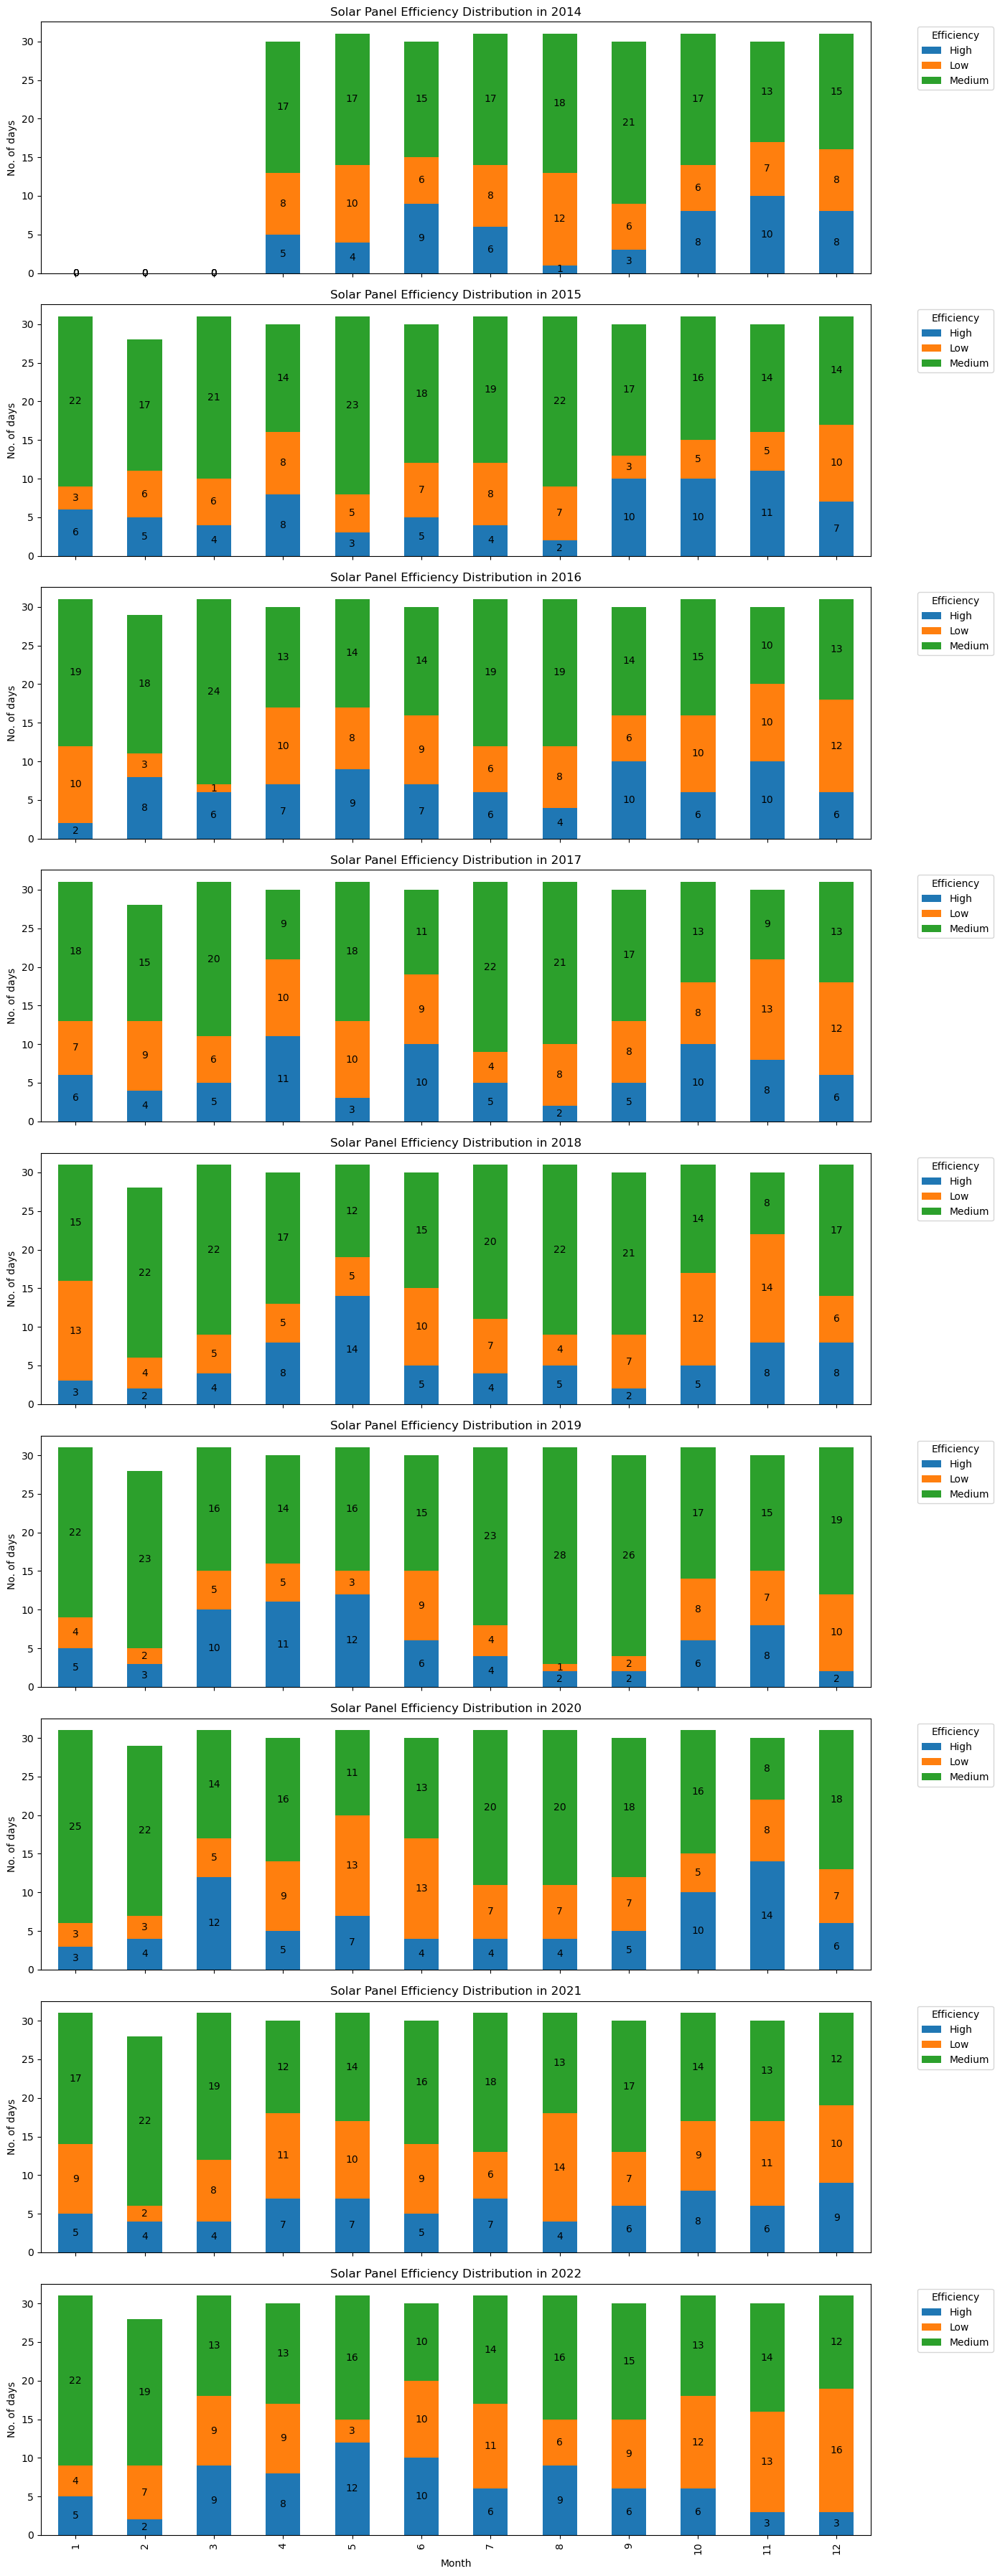

In [20]:
# Extract year and month from date
merged_df['year'] = merged_df['date'].dt.year
merged_df['month'] = merged_df['date'].dt.month

# List the range of years to plot
years_to_plot = list(range(2014, 2023))

# Create a figure and axis
fig, axes = plt.subplots(len(years_to_plot), 1, figsize=(14, 4 * len(years_to_plot)), sharex=True)

# Iterate over each year and plot
for i, year in enumerate(years_to_plot):
    filtered_df = merged_df[merged_df['year'] == year]

    # Add dummy data for the first three months of 2014
    if year == 2014:
        dummy_data = {'month': [1, 2, 3], 'Daily Solar Panel Efficiency': ['High', 'Medium', 'Low']}
        dummy_df = pd.DataFrame(dummy_data)
        dummy_df['count'] = 0
        dummy_df = dummy_df.pivot(index='month', columns='Daily Solar Panel Efficiency', values='count').fillna(0)
        
        monthly_efficiency = filtered_df.groupby(['month', 'Daily Solar Panel Efficiency']).size().unstack(fill_value=0)
        monthly_efficiency = pd.concat([dummy_df, monthly_efficiency]).fillna(0)
    else:
        monthly_efficiency = filtered_df.groupby(['month', 'Daily Solar Panel Efficiency']).size().unstack(fill_value=0)
    
    # Plotting
    ax = axes[i]
    monthly_efficiency.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_title(f'Solar Panel Efficiency Distribution in {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('No. of days')
    ax.legend(title='Efficiency', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Annotate each bar with its height
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

plt.tight_layout()
plt.show()

# You can visualize the number of days with high efficiency each month and observe how this trend has developed over the years.
Based on the previous heatmap, factors such as PM 2.5, PSI, air pressure, dew point category, minimum wind speed, and wet bulb temperature have minimal impact on solar panel efficiency according to the data. Unless great changes happening for instance all the minimal effects components increase exponentially.

Apart from environmental factor, the months with the least high efficiency output are Jan, Feb and Aug(exclude 2022) every year. Is there any difficulties in the hardwares during this month or is it due to other factors?

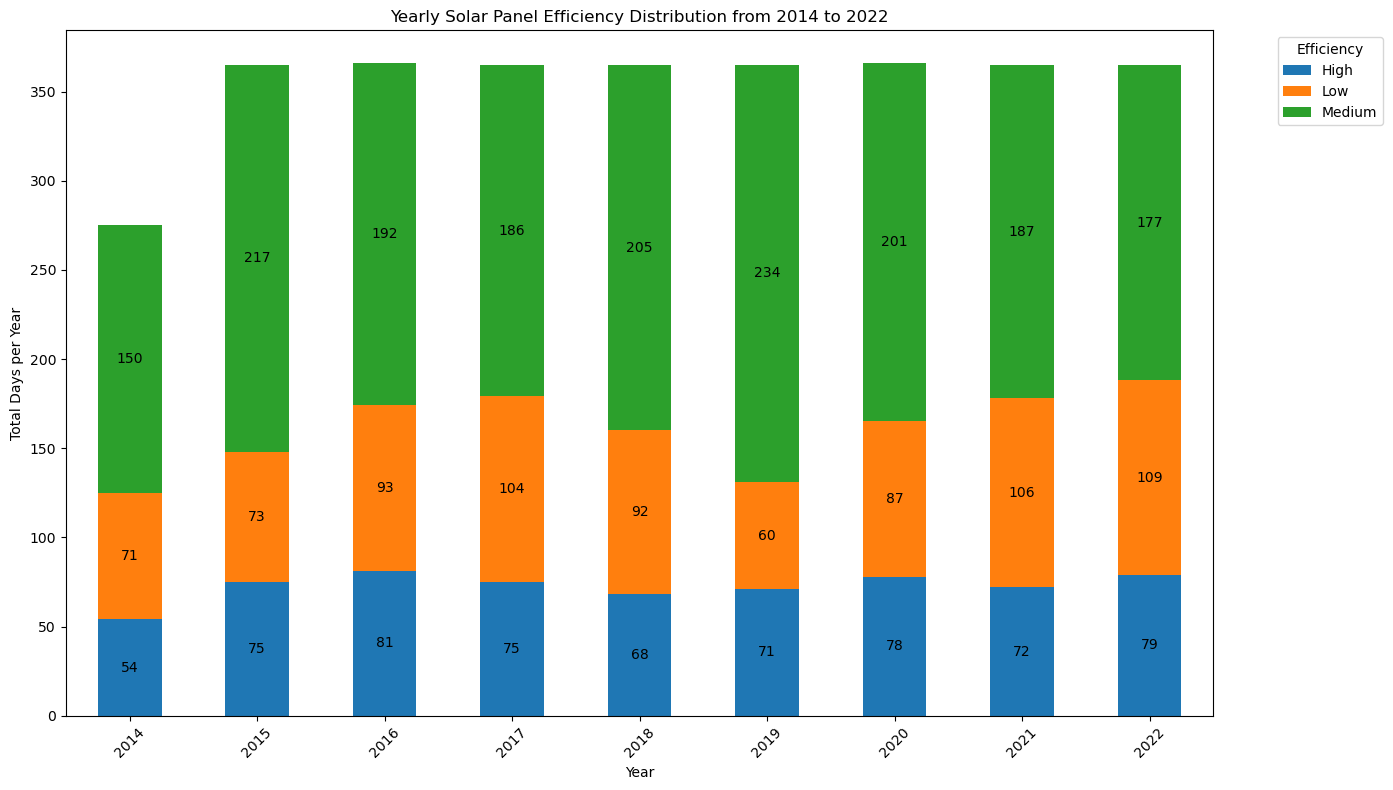

In [21]:
# Group by year and Daily Solar Panel Efficiency and sum the counts
yearly_efficiency = merged_df.groupby(['year', 'Daily Solar Panel Efficiency']).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

yearly_efficiency.plot(kind='bar', stacked=True, ax=ax)

plt.title('Yearly Solar Panel Efficiency Distribution from 2014 to 2022')
plt.xlabel('Year')
plt.ylabel('Total Days per Year')
plt.xticks(rotation=45)
plt.legend(title='Efficiency', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate each bar with its height
for container in ax.containers:
    ax.bar_label(container, label_type='center')

plt.tight_layout()
plt.show()

# Visualize the trend developed over years.
You can see an upward trend of more days with low efficiency output from 2019 till 2022. Is it the hardware aging that contributes to these trends? Or is there any obstacle that blocks the sunlight? For example, a growing tree, fallen leaves, animals droppings.